## CIFAR10
  - 10 categories of 32 x 32 sized color images
  - 50000 training and 10000 testing samples
  
The full CIFAR dataset contains 80 million tiny colored images.
  - The main page: https://www.cs.toronto.edu/%7Ekriz/cifar.html
  - About CIFAR: https://www.cs.toronto.edu/%7Ekriz/learning-features-2009-TR.pdf

In [267]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

import tensorflow as tf

tf.random.set_seed(42)

import tensorflow.keras as keras

In [268]:
import os
from functools import partial

from sklearn.model_selection import StratifiedShuffleSplit

from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Activation, \
                                    Dropout, AlphaDropout
from tensorflow.keras.optimizers import Nadam, SGD
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

from sklearn.metrics import accuracy_score

## You can download the data from the original link above and load it like this ...

In [48]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

file_dicts = {}
for i in range(1, 6):
    batch = f'data_batch_{i}'
    filename = os.path.join('.', 'data', 'cifar', 'cifar-10-batches-py', batch)
    file_dicts[i-1] = unpickle(filename)

In [49]:
def append_data(data, type_):
    a = data[0][type_]
    for i in range(1, 5):
        a = np.r_[a, data[i][type_]]
    return a

In [50]:
X_full = append_data(file_dicts, b'data')
y_full = append_data(file_dicts, b'labels')

In [51]:
X_full.shape, y_full.shape

((50000, 3072), (50000,))

In [52]:
test_file = os.path.join('.', 'data', 'cifar', 'cifar-10-batches-py', 'test_batch')
test_file_dict = unpickle(test_file)

In [53]:
X_test = test_file_dict[b'data']
y_test = test_file_dict[b'labels']

In [54]:
len(X_test), len(y_test)

(10000, 10000)

In [55]:
# Use StratifiedShuffleSplit to split training data into training and validation. 
# This will ensure that the training and validation data has an equal proportion of classes.
#
split = StratifiedShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2) # We don't need to specify both test/train.
                                                                          # sizes, but it is good for clarity.
for train_idx, test_idx in split.split(X_full, y_full):
    X_train, X_val = X_full[train_idx], X_full[test_idx]
    y_train, y_val = y_full[train_idx], y_full[test_idx]

In [56]:
X_train.shape, len(y_train), X_test.shape, len(y_test)

((40000, 3072), 40000, (10000, 3072), 10000)

In [57]:
# Validate that the split shows the correct proportion of classes
pd.Series(y_train).value_counts(normalize=True), pd.Series(y_val).value_counts(normalize=True)

(9    0.1
 8    0.1
 7    0.1
 6    0.1
 5    0.1
 4    0.1
 3    0.1
 2    0.1
 1    0.1
 0    0.1
 dtype: float64, 7    0.1
 6    0.1
 5    0.1
 4    0.1
 3    0.1
 2    0.1
 9    0.1
 1    0.1
 8    0.1
 0    0.1
 dtype: float64)

## ... or an easier way is to use Tensorflow's load_data() function

In [58]:
(X_train, y_train), (X_test, y_test) = load_data()

In [59]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.flatten()
y_test = y_test.flatten()

In [60]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 3072), (50000,), (10000, 3072), (10000,))

In [61]:
# Validate that the split shows the correct proportion of classes
pd.Series(y_train).value_counts(normalize=True), pd.Series(y_test).value_counts(normalize=True)

(9    0.1
 8    0.1
 7    0.1
 6    0.1
 5    0.1
 4    0.1
 3    0.1
 2    0.1
 1    0.1
 0    0.1
 dtype: float64, 7    0.1
 6    0.1
 5    0.1
 4    0.1
 3    0.1
 2    0.1
 9    0.1
 1    0.1
 8    0.1
 0    0.1
 dtype: float64)

In [62]:
# Use StratifiedShuffleSplit to split training data into training and validation. 
# This will ensure that the training and validation data has an equal proportion of classes.
#
split = StratifiedShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2) # We don't need to specify both test/train.
                                                                          # sizes, but it is good for clarity.
for train_idx, test_idx in split.split(X_train, y_train):
    X_train_1, X_val = X_train[train_idx], X_train[test_idx]
    y_train_1, y_val = y_train[train_idx], y_train[test_idx]

X_train = X_train_1
y_train = y_train_1

In [63]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((40000, 3072), (40000,), (10000, 3072), (10000,))

## Create a model with Batch Normalization layers

In [200]:
class MCDropout(Dropout):
    def call(self, rate):
        return super().call(rate, training=True)    # When training = True, the Dropout class from which we inherit
                                                    # MCDropout drops some of the cells in the layer.
                                                    # When cells are dropped, the model we're training is different.
                                                    # We get the benefit of running thousands of models on the data.
                                                    # The final model is also more robust to small changes in input.
                                                    # MC Dropout acts as a regularizer.
                        
def create_model(with_bn=False,
                 initialization='he_normal',
                 hidden_activation='elu',
                 dropout_rate=None,
                 mc_dropout=False):
    
    def add_dropout_layer(layer_num=None, dropout_rate=None, mc_dropout=False):
        
        assert(layer_num is not None)
        if dropout_rate is not None:
            if layer_num > 16:                                   # For the last 3 layers, add AlphaDropout layer
                if mc_dropout == True:
                    model.add(MCDropout(dropout_rate))
                else:
                    model.add(AlphaDropout(dropout_rate))
        
        
    model = Sequential([
        InputLayer(input_shape=[3072])
    ])

    if with_bn:
        model.add(BatchNormalization())                           # Add BN layer after input

    NormalDense = partial(Dense,                                  # Put all your common init here.
                          kernel_initializer=initialization,
                          use_bias=False if with_bn else True)    # BN has bias, so remove it
                                                                  # from the Dense layer.

    for layer_num in range(20):
        model.add(NormalDense(100))
        
        if with_bn:                                               # Add a BatchNormalization layer after each
            model.add(BatchNormalization())                       # Dense layer
        
        model.add(Activation(hidden_activation))                  # Add an activation function. This is needed
                                                                  # because we did not add it when we created the
                                                                  # partial dense layer
        
        add_dropout_layer(layer_num, dropout_rate, mc_dropout)    # Add dropout layer
        
    model.add(Dense(10, activation='softmax'))                    # Output layer
    
    return model

In [66]:
model = create_model(with_bn=False)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_123 (Dense)            (None, 100)               307300    
_________________________________________________________________
activation_118 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_124 (Dense)            (None, 100)               10100     
_________________________________________________________________
activation_119 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_125 (Dense)            (None, 100)               10100     
_________________________________________________________________
activation_120 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_126 (Dense)            (None, 100)              

In [67]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

In [68]:
early_stopping_cb = EarlyStopping(patience=10,
                                  restore_best_weights=True)

In [69]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping_cb])

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 14s 349us/sample - loss: 3.6506 - accuracy: 0.2109 - val_loss: 1.9432 - val_accuracy: 0.2835
Epoch 2/100
40000/40000 [==============================] - 11s 266us/sample - loss: 1.9259 - accuracy: 0.2925 - val_loss: 1.8649 - val_accuracy: 0.3031
Epoch 3/100
40000/40000 [==============================] - 11s 266us/sample - loss: 1.8634 - accuracy: 0.3218 - val_loss: 1.9870 - val_accuracy: 0.2906
Epoch 4/100
40000/40000 [==============================] - 11s 265us/sample - loss: 1.8350 - accuracy: 0.3311 - val_loss: 1.8542 - val_accuracy: 0.3318
Epoch 5/100
40000/40000 [==============================] - 11s 264us/sample - loss: 1.8148 - accuracy: 0.3446 - val_loss: 1.8541 - val_accuracy: 0.3084
Epoch 6/100
40000/40000 [==============================] - 11s 265us/sample - loss: 1.7967 - accuracy: 0.3493 - val_loss: 1.7602 - val_accuracy: 0.3623
Epoch 7/100
40000/40000 [=============

In [70]:
model = create_model(with_bn=True)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_21 (Batc (None, 3072)              12288     
_________________________________________________________________
dense_144 (Dense)            (None, 100)               307200    
_________________________________________________________________
batch_normalization_22 (Batc (None, 100)               400       
_________________________________________________________________
activation_138 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_145 (Dense)            (None, 100)               10000     
_________________________________________________________________
batch_normalization_23 (Batc (None, 100)               400       
_________________________________________________________________
activation_139 (Activation)  (None, 100)              

In [71]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

In [72]:
early_stopping_cb = EarlyStopping(patience=10,
                                  restore_best_weights=True)

In [73]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping_cb])

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 24s 589us/sample - loss: 1.8532 - accuracy: 0.3353 - val_loss: 1.6860 - val_accuracy: 0.3923
Epoch 2/100
40000/40000 [==============================] - 16s 409us/sample - loss: 1.6913 - accuracy: 0.3943 - val_loss: 1.6536 - val_accuracy: 0.4035
Epoch 3/100
40000/40000 [==============================] - 16s 408us/sample - loss: 1.6207 - accuracy: 0.4211 - val_loss: 1.5588 - val_accuracy: 0.4403
Epoch 4/100
40000/40000 [==============================] - 16s 406us/sample - loss: 1.5730 - accuracy: 0.4424 - val_loss: 1.5318 - val_accuracy: 0.4502
Epoch 5/100
40000/40000 [==============================] - 16s 408us/sample - loss: 1.5327 - accuracy: 0.4546 - val_loss: 1.5035 - val_accuracy: 0.4626
Epoch 6/100
40000/40000 [==============================] - 16s 403us/sample - loss: 1.5001 - accuracy: 0.4692 - val_loss: 1.4783 - val_accuracy: 0.4739
Epoch 7/100
40000/40000 [=============

In [74]:
# Standardize data so you can use it with SELU and 
# get a net that self-normalizes
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_val = (X_val - np.mean(X_val)) / np.std(X_val)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

In [75]:
# Verify data is standardized
X_train[:1], X_val[:1], X_test[:1]

(array([[-0.25880869,  0.17801875,  0.69285109, ..., -0.18080379,
          0.05321091,  0.36523051]]),
 array([[-0.23589639,  0.50998215,  2.00173923, ..., -0.00280935,
          0.82076487,  2.06389577]]),
 array([[ 0.56931459, -0.14875133, -1.13218945, ..., -1.56927306,
         -0.85120713, -0.17997159]]))

In [102]:
model = create_model(with_bn=False, 
                     initialization='lecun_normal', 
                     hidden_activation='selu')
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_312 (Dense)            (None, 100)               307300    
_________________________________________________________________
activation_298 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_313 (Dense)            (None, 100)               10100     
_________________________________________________________________
activation_299 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_314 (Dense)            (None, 100)               10100     
_________________________________________________________________
activation_300 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_315 (Dense)            (None, 100)             

In [103]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

In [104]:
early_stopping_cb = EarlyStopping(patience=10,
                                  restore_best_weights=True)

In [105]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping_cb])

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 17s 429us/sample - loss: 1.9997 - accuracy: 0.2793 - val_loss: 1.9119 - val_accuracy: 0.3134
Epoch 2/100
40000/40000 [==============================] - 13s 334us/sample - loss: 1.7919 - accuracy: 0.3595 - val_loss: 1.7603 - val_accuracy: 0.3642
Epoch 3/100
40000/40000 [==============================] - 13s 327us/sample - loss: 1.6992 - accuracy: 0.3954 - val_loss: 1.6612 - val_accuracy: 0.4153
Epoch 4/100
40000/40000 [==============================] - 13s 319us/sample - loss: 1.6338 - accuracy: 0.4193 - val_loss: 1.6965 - val_accuracy: 0.4068
Epoch 5/100
40000/40000 [==============================] - 13s 325us/sample - loss: 1.5825 - accuracy: 0.4399 - val_loss: 1.6449 - val_accuracy: 0.4098
Epoch 6/100
40000/40000 [==============================] - 13s 323us/sample - loss: 1.5399 - accuracy: 0.4574 - val_loss: 1.6097 - val_accuracy: 0.4343
Epoch 7/100
40000/40000 [=============

In [106]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
print(f'accuracy for model: {accuracy_score(y_val, y_pred_classes)}')

accuracy for model: 0.4815


In [87]:
models = []
for i in range(4):
    
    dropout_rate = 0.1 * (i + 1)  # Try different dropout rates for your model.
                                  # For a self-normalizing model:
                                  #  - use only Dense layers
                                  #  - standardize the input features
                                  #  - use LeCun initialization + SELU activation
    
    model = create_model(with_bn=False, 
                         initialization='lecun_normal', 
                         hidden_activation='selu',
                         dropout_rate=dropout_rate)
    # model.summary()
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='nadam',
                  metrics=['accuracy'])

    early_stopping_cb = EarlyStopping(patience=10,
                                      restore_best_weights=True)
    
    print(f'    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    print(f'    >>>>>>>>>>>>>>>>> For dropout_rate: {dropout_rate}')
    print(f'    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    history = model.fit(X_train, y_train, epochs=100,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping_cb])
    
    models.append(model)

    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    >>>>>>>>>>>>>>>>> For dropout_rate: 0.1
    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 17s 431us/sample - loss: 2.0255 - accuracy: 0.2648 - val_loss: 1.8834 - val_accuracy: 0.3092
Epoch 2/100
40000/40000 [==============================] - 13s 334us/sample - loss: 1.8020 - accuracy: 0.3510 - val_loss: 1.8001 - val_accuracy: 0.3721
Epoch 3/100
40000/40000 [==============================] - 14s 340us/sample - loss: 1.7282 - accuracy: 0.3816 - val_loss: 1.8310 - val_accuracy: 0.3827
Epoch 4/100
40000/40000 [==============================] - 13s 335us/sample - loss: 1.6758 - accuracy: 0.4024 - val_loss: 1.7611 - val_accuracy: 0.3904
Epoch 5/100
40000/40000 [==============================] - 13s 333us/sample - loss: 1.6364 - accuracy: 0.4193 - val_loss: 1.7034 - val_accuracy: 0.3962
Epoch 6/100
40000/40000 [===========

40000/40000 [==============================] - 17s 428us/sample - loss: 2.1505 - accuracy: 0.1981 - val_loss: 2.4525 - val_accuracy: 0.2382
Epoch 2/100
40000/40000 [==============================] - 13s 315us/sample - loss: 1.9503 - accuracy: 0.2567 - val_loss: 2.7655 - val_accuracy: 0.2759
Epoch 3/100
40000/40000 [==============================] - 12s 311us/sample - loss: 1.8794 - accuracy: 0.2859 - val_loss: 2.5817 - val_accuracy: 0.3128
Epoch 4/100
40000/40000 [==============================] - 12s 310us/sample - loss: 1.8218 - accuracy: 0.3044 - val_loss: 2.5179 - val_accuracy: 0.3049
Epoch 5/100
40000/40000 [==============================] - 12s 308us/sample - loss: 1.8064 - accuracy: 0.3118 - val_loss: 2.2399 - val_accuracy: 0.3167
Epoch 6/100
40000/40000 [==============================] - 13s 314us/sample - loss: 1.7848 - accuracy: 0.3213 - val_loss: 2.6289 - val_accuracy: 0.3569
Epoch 7/100
40000/40000 [==============================] - 12s 311us/sample - loss: 1.7612 - accurac

In [123]:
for i in range(4):
    model = models[i]
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print(f'accuracy for model {i+1}: {accuracy_score(y_test, y_pred_classes)}')

accuracy for model 1: 0.4238
accuracy for model 2: 0.3692
accuracy for model 3: 0.329
accuracy for model 4: 0.3258


### Without dropout, with LeCun initialization, and SELU activation, we get accuracy of 0.48. 
### With dropout, the best model gives us accuracy of 0.42
### Now let's try retraining the same model with MC Dropout to see if we get better results

In [124]:
model = models[0]

y_probas = np.stack([model(X_test, training=True) for _ in range(100)])
y_proba = np.mean(y_probas, axis=0)

In [125]:
y_pred = np.argmax(y_proba, axis=1)
print(f'accuracy for model with dropout: {accuracy_score(y_test, y_pred)}')

accuracy for model with dropout: 0.4209


### MC Dropout does not give us any better results, but the model is regularized, so it will be better on different test sets

### Now let's try it using MCDropout with Batch Normalization

In [126]:
model.layers

In [189]:
model_mc_dropout = tf.keras.models.clone_model(model) # Everything in the model except the weights are cloned.
model_mc_dropout.set_weights(model.get_weights())     # Cloning does not clone weights, so set them instead

In [190]:
model_mc_dropout.layers[0].get_weights()

[array([[-0.01139602,  0.00754124, -0.13820025, ...,  0.04770136,
         -0.05793469, -0.00654243],
        [-0.01611584,  0.01971314, -0.13340402, ..., -0.01504751,
         -0.11105145, -0.01809836],
        [-0.02463305, -0.10309125, -0.07891604, ...,  0.0674312 ,
         -0.09133004, -0.03442317],
        ...,
        [-0.13616231,  0.13149257,  0.14802764, ..., -0.08039837,
          0.0171286 ,  0.0174218 ],
        [-0.11005429,  0.10675663,  0.07581476, ..., -0.06333005,
         -0.03798052, -0.03497659],
        [ 0.05426489,  0.11429682, -0.04324795, ...,  0.07633459,
         -0.03089878,  0.13195276]], dtype=float32),
 array([-0.4149874 , -0.20836446, -0.01339994, -0.0818699 ,  0.12745625,
         0.11542892, -0.22220957,  0.12931274, -0.16048275, -0.05801518,
        -0.14564976, -0.09795307, -0.08613658, -0.25908798, -0.33447212,
        -0.16124682, -0.23373884, -0.11296007, -0.22040613, -0.1159159 ,
         0.06676819, -0.17070751, -0.41194272, -0.29696104, -0.159

In [191]:
# We remove the last 10 model layers including the output layer.
# The output layer is a single layer.
# The layers before that are combined of both Dense and Activation.
# So we remove the single output layer, and 3 (Dense + Activation)
# layers. We found this out by looking at the model.layers
print(f'Number of layers in model: {len(model_mc_dropout.layers)}')
for _ in range(10):
    model_mc_dropout.pop()
print(f'Number of layers in model: {len(model_mc_dropout.layers)}')

Number of layers in model: 44
Number of layers in model: 34


In [192]:
# Add (3 Dense layers + MC Dropout) layers
for i in range(3):
    model_mc_dropout.add(Dense(100, 
                               kernel_initializer='lecun_normal',
                               activation='selu'))
    model_mc_dropout.add(MCDropout(0.1))

In [193]:
# Add output layer
model_mc_dropout.add(Dense(10, activation='softmax'))

In [194]:
model_mc_dropout.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_228 (Dense)            (None, 100)               307300    
_________________________________________________________________
activation_218 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_229 (Dense)            (None, 100)               10100     
_________________________________________________________________
activation_219 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_230 (Dense)            (None, 100)               10100     
_________________________________________________________________
activation_220 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_231 (Dense)            (None, 100)             

In [197]:
model = model_mc_dropout
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping_cb])

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 18s 439us/sample - loss: 1.6687 - accuracy: 0.4299 - val_loss: 1.6654 - val_accuracy: 0.4189
Epoch 2/100
40000/40000 [==============================] - 13s 336us/sample - loss: 1.5231 - accuracy: 0.4633 - val_loss: 1.6176 - val_accuracy: 0.4261
Epoch 3/100
40000/40000 [==============================] - 14s 339us/sample - loss: 1.4742 - accuracy: 0.4845 - val_loss: 1.6120 - val_accuracy: 0.4353
Epoch 4/100
40000/40000 [==============================] - 14s 340us/sample - loss: 1.4295 - accuracy: 0.4994 - val_loss: 1.5756 - val_accuracy: 0.4481
Epoch 5/100
40000/40000 [==============================] - 14s 340us/sample - loss: 1.4083 - accuracy: 0.5119 - val_loss: 1.7540 - val_accuracy: 0.4181
Epoch 6/100
40000/40000 [==============================] - 14s 342us/sample - loss: 1.4238 - accuracy: 0.4983 - val_loss: 1.5740 - val_accuracy: 0.4624
Epoch 7/100
40000/40000 [=============

In [198]:
y_probas = np.stack([model(X_test, training=True) for _ in range(100)])
y_proba = np.mean(y_probas, axis=0)

In [199]:
y_pred = np.argmax(y_proba, axis=1)
print(f'accuracy for model with dropout: {accuracy_score(y_test, y_pred)}')

accuracy for model with dropout: 0.4929


### With MC dropout, accuracy improved from 0.42 to 0.49, an increase of 0.07.
### This means error decreased from 0.58 to 0.51, a decrease of 7% - not bad for a small change in the model

In [326]:
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):

    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Training Loss")
    
# These two classes can be used when your optimizer uses momentum.
# In this case, when your learning rate is going down,
# momentum should be going up, and vice versa.
#
class LinearBeta_1(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
    def on_batch_end(self, batch, logs):
        K.set_value(self.model.optimizer.beta_1, self.model.optimizer.beta_1 + self.factor)

def find_learning_rate_with_momentum(model, X, y, epochs=1, batch_size=32, 
                                     min_rate=10**-5, max_rate=10,
                                     start_beta_1=0.95, end_beta_1=0.85):

    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    factor_beta_1 = (start_beta_1 - end_beta_1) / iterations
    
    init_lr = K.get_value(model.optimizer.lr)
    init_beta_1 = K.get_value(model.optimizer.beta_1)
    
    K.set_value(model.optimizer.lr, min_rate)
    K.set_value(model.optimizer.beta_1, start_beta_1)
    
    exp_lr = ExponentialLearningRate(factor)
    lin_beta_1 = LinearBeta_1(factor_beta_1)
    
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr, lin_beta_1])
    
    K.set_value(model.optimizer.lr, init_lr)
    K.set_value(model.optimizer.beta_1, init_beta_1)

    model.set_weights(init_weights)
    model.beta_1 = init_beta_1
    
    return exp_lr.rates, exp_lr.losses

In [331]:
model = create_model(with_bn=False, 
                     initialization='lecun_normal', 
                     hidden_activation='selu')
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_725 (Dense)            (None, 100)               307300    
_________________________________________________________________
activation_678 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_726 (Dense)            (None, 100)               10100     
_________________________________________________________________
activation_679 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_727 (Dense)            (None, 100)               10100     
_________________________________________________________________
activation_680 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_728 (Dense)            (None, 100)             

In [332]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

Train on 40000 samples
40000/40000 [==============================] - 9s 229us/sample - loss: nan - accuracy: 0.1650


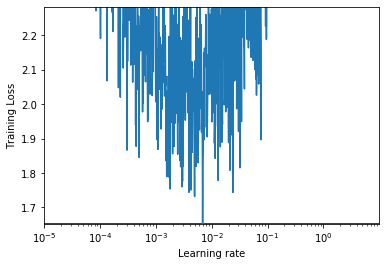

In [333]:
batch_size = 32
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

### Lowest LR from the plot to is around 3e-3. So select starting LR to be 5e-3

In [327]:
# This shows how you can ramp up on the LR rate and ramp down on it at the halfway point.
#
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
        self.rates = []
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (iter2 - self.iteration)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        self.rates.append(rate)
        K.set_value(self.model.optimizer.lr, rate)
        
class OneCycleSchedulerWithMomentum(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None,
                 start_momentum=0.95, end_momentum=0.85):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.start_momentum = start_momentum
        self.end_momentum = end_momentum
        self.iteration = 0
        self.rates = []
        self.momentums = []
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (iter2 - self.iteration)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
            momentum = self._interpolate(0, self.half_iteration, 
                                        self.start_momentum, self.end_momentum)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
            momentum = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.end_momentum, self.start_momentum)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            momentum = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_momentum, self.end_momentum)
            rate = max(rate, self.last_rate)
            momentum = self.start_momentum
        self.iteration += 1
        self.rates.append(rate)
        self.momentums.append(momentum)
        K.set_value(self.model.optimizer.lr, rate)
        K.set_value(self.model.optimizer.beta_1, momentum)

In [285]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=5e-3)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=[onecycle])

Train on 40000 samples, validate on 10000 samples
Epoch 1/25
40000/40000 [==============================] - 9s 227us/sample - loss: 1.8345 - accuracy: 0.3392 - val_loss: 1.7438 - val_accuracy: 0.3762
Epoch 2/25
40000/40000 [==============================] - 9s 216us/sample - loss: 1.6224 - accuracy: 0.4205 - val_loss: 1.6452 - val_accuracy: 0.4029
Epoch 3/25
40000/40000 [==============================] - 9s 221us/sample - loss: 1.5203 - accuracy: 0.4575 - val_loss: 1.5755 - val_accuracy: 0.4413
Epoch 4/25
40000/40000 [==============================] - 9s 220us/sample - loss: 1.4461 - accuracy: 0.4864 - val_loss: 1.5515 - val_accuracy: 0.4521
Epoch 5/25
40000/40000 [==============================] - 9s 221us/sample - loss: 1.3826 - accuracy: 0.5072 - val_loss: 1.5309 - val_accuracy: 0.4605
Epoch 6/25
40000/40000 [==============================] - 9s 230us/sample - loss: 1.3250 - accuracy: 0.5287 - val_loss: 1.5138 - val_accuracy: 0.4670
Epoch 7/25
40000/40000 [==========================

### If you compare the losses for each epoch above with the plot earlier where we scanned the learning rate, you will see that we should get a loss around 1.6.  This is indeed what we get when we use the 1cycle scheduler.

### What can we do, and what does not work with 1cycle learning rate scheduling:
  - Cannot use dropout since dropout keeps changing the network for each batch.
    Here we want to cycle through the learning rate in a particular sequence
    for the same network
  - Cannot use early stopping since our run through the learning rates will not be complete

In [286]:
min(onecycle.rates), max(onecycle.rates)

(5e-07, 0.005000000000000001)

[0, 40000, -0.001, 0.001]

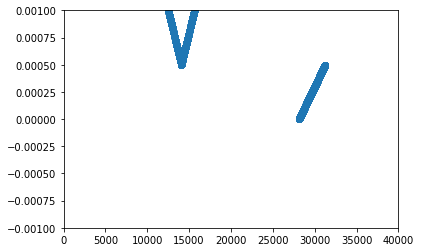

In [287]:
plt.scatter(range(len(onecycle.rates)), onecycle.rates)
plt.axis([0, 40000, -0.001, 0.001])

### Let's see if we can use He initialization and ELU activation to get good results with 1cycle learning schedule

In [288]:
model = create_model(with_bn=False, 
                     initialization='he_normal', 
                     hidden_activation='elu')
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_599 (Dense)            (None, 100)               307300    
_________________________________________________________________
activation_558 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_600 (Dense)            (None, 100)               10100     
_________________________________________________________________
activation_559 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_601 (Dense)            (None, 100)               10100     
_________________________________________________________________
activation_560 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_602 (Dense)            (None, 100)             

In [289]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

Train on 40000 samples
40000/40000 [==============================] - 8s 193us/sample - loss: nan - accuracy: 0.1401


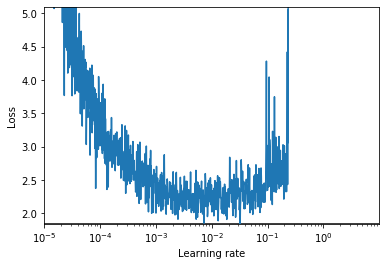

In [290]:
batch_size = 32
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(onecycle.rates, onecycle.losses)

In [291]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=1e-2)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=[onecycle])

Train on 40000 samples, validate on 10000 samples
Epoch 1/25
40000/40000 [==============================] - 8s 199us/sample - loss: 1.9359 - accuracy: 0.2977 - val_loss: 1.7862 - val_accuracy: 0.3573
Epoch 2/25
40000/40000 [==============================] - 8s 192us/sample - loss: 1.6839 - accuracy: 0.3961 - val_loss: 1.6741 - val_accuracy: 0.4022
Epoch 3/25
40000/40000 [==============================] - 8s 191us/sample - loss: 1.5663 - accuracy: 0.4415 - val_loss: 1.6091 - val_accuracy: 0.4245
Epoch 4/25
40000/40000 [==============================] - 8s 192us/sample - loss: 1.4854 - accuracy: 0.4708 - val_loss: 1.6187 - val_accuracy: 0.4230
Epoch 5/25
40000/40000 [==============================] - 8s 189us/sample - loss: 1.4186 - accuracy: 0.4965 - val_loss: 1.5697 - val_accuracy: 0.4398
Epoch 6/25
40000/40000 [==============================] - 8s 191us/sample - loss: 1.3539 - accuracy: 0.5212 - val_loss: 1.5529 - val_accuracy: 0.4473
Epoch 7/25
40000/40000 [==========================

### Accuracy as with lecun_normal initialization and SELU activation = 0.5
### Accuracy with he_normal initialization and ELU activation = 0.48

In [292]:
model = create_model(with_bn=False, 
                     initialization='he_normal', 
                     hidden_activation='elu')
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_620 (Dense)            (None, 100)               307300    
_________________________________________________________________
activation_578 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_621 (Dense)            (None, 100)               10100     
_________________________________________________________________
activation_579 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_622 (Dense)            (None, 100)               10100     
_________________________________________________________________
activation_580 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_623 (Dense)            (None, 100)             

In [293]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

Train on 40000 samples
40000/40000 [==============================] - 15s 382us/sample - loss: 8621276790.3577 - accuracy: 0.1392


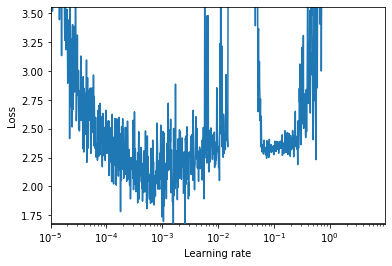

In [294]:
batch_size = 32
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(onecycle.rates, onecycle.losses)

In [295]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=3e-3)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=[onecycle])

Train on 40000 samples, validate on 10000 samples
Epoch 1/25
40000/40000 [==============================] - 14s 339us/sample - loss: 2.1133 - accuracy: 0.2258 - val_loss: 2.0406 - val_accuracy: 0.2417
Epoch 2/25
40000/40000 [==============================] - 13s 333us/sample - loss: 1.9822 - accuracy: 0.2693 - val_loss: 2.0095 - val_accuracy: 0.2601
Epoch 3/25
40000/40000 [==============================] - 13s 334us/sample - loss: 1.9424 - accuracy: 0.2866 - val_loss: 1.9505 - val_accuracy: 0.2855
Epoch 4/25
40000/40000 [==============================] - 13s 332us/sample - loss: 1.9127 - accuracy: 0.2995 - val_loss: 1.9405 - val_accuracy: 0.2900
Epoch 5/25
40000/40000 [==============================] - 13s 336us/sample - loss: 1.8880 - accuracy: 0.3131 - val_loss: 1.9094 - val_accuracy: 0.2998
Epoch 6/25
40000/40000 [==============================] - 13s 332us/sample - loss: 1.8657 - accuracy: 0.3228 - val_loss: 1.9069 - val_accuracy: 0.3069
Epoch 7/25
40000/40000 [====================

### Since Nadam optimizer uses momentum, let's try decreasing the momentum as we increase the learning rate, and increasing the momentum as we decrease the learning rate

In [340]:
model = create_model(with_bn=False, 
                     initialization='he_normal', 
                     hidden_activation='elu')
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Train on 40000 samples
40000/40000 [==============================] - 10s 241us/sample - loss: 247.6681 - accuracy: 0.1553


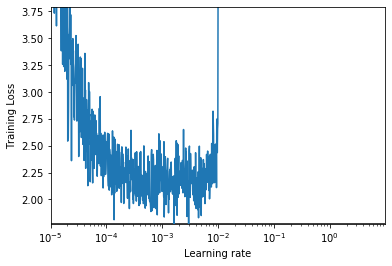

In [341]:
batch_size = 32
rates, losses = find_learning_rate_with_momentum(model, 
                                                 X_train, y_train, epochs=1, 
                                                 batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [342]:
n_epochs = 5
onecycle = OneCycleSchedulerWithMomentum(len(X_train) // batch_size * n_epochs, 
                                         max_rate=5e-3)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=[onecycle])

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 9s 228us/sample - loss: nan - accuracy: 0.1001 - val_loss: nan - val_accuracy: 0.1000
Epoch 2/5
40000/40000 [==============================] - 9s 221us/sample - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 3/5
40000/40000 [==============================] - 9s 224us/sample - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 4/5
40000/40000 [==============================] - 9s 223us/sample - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 5/5
40000/40000 [==============================] - 9s 223us/sample - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000


In [343]:
min(onecycle.momentums), max(onecycle.momentums), min(onecycle.rates), max(onecycle.rates)

(0.85, 0.95, 5e-07, 0.005000000000000001)

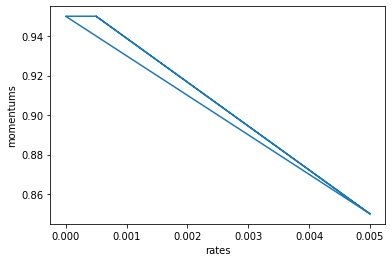

In [349]:
plt.plot(onecycle.rates, onecycle.momentums);
plt.gca().set_xlabel('rates');
plt.gca().set_ylabel('momentums');